In [1]:
from PIL import Image
import pandas as pd
import os
import torch
from skimage import io, transform
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import random

In [2]:
class ArtDataset(Dataset):
    def __init__(self,  csv_file, img_dir, transform=None): 
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        
        self.data_info = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.data_info)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        img_name = os.path.join(self.img_dir,
                                self.data_info.iloc[idx, 0])
        
        image = Image.open(img_name).convert('RGB')
        
        a = np.asarray(image)
        #print(a.shape, img_name)
        date = self.data_info.iloc[idx, 1]
        
        if self.transform:
            image = self.transform(image)
            
        sample = {'image': image, 'date': date}
        return sample

### Test on the dataset

0 <PIL.Image.Image image mode=RGB size=64x64 at 0x12D9B0B90>
1 <PIL.Image.Image image mode=RGB size=64x64 at 0x12CFCB050>
2 <PIL.Image.Image image mode=RGB size=64x64 at 0x12D23CB90>


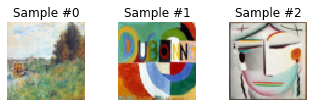

In [3]:
art_data_tensor = ArtDataset(csv_file = 'train_1_info.csv', img_dir = 'train_1/', 
                     transform = transforms.Compose([transforms.Resize((256,256)), transforms.ToTensor(),
                                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                         std=[0.229, 0.224, 0.225])]))


test_ds_pil = ArtDataset(csv_file = 'train_1_info.csv', img_dir = 'train_1/', 
                     transform = transforms.Compose([transforms.Resize((256,256)),
                                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                         std=[0.229, 0.224, 0.225])]))

#test_ds_pil = ArtDataset(csv_file = 'train_1_info.csv', img_dir = 'train_1/', 
                     #transform =None)
fig = plt.figure()

for i in range(3):
    sample = test_ds_pil[i]
    print(i, sample['image'])
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plt.imshow(sample['image'])
    
 

    

In [4]:
indicies = np.arange(len(art_data_tensor))
random.Random(148).shuffle(indicies)
split_index1 = int(len(art_data_tensor) * 0.68)
split_index2 = int(len(art_data_tensor) * 0.8)
subset_indices_train = indicies[:split_index1]
subset_indices_valid = indicies[split_index1:split_index2]
subset_indices_test = indicies[-split_index2:]
train_loader = torch.utils.data.DataLoader(art_data_tensor, batch_size=32,
                                           sampler=SubsetRandomSampler(subset_indices_train))
val_loader = torch.utils.data.DataLoader(art_data_tensor, batch_size=32,
                                         sampler=SubsetRandomSampler(subset_indices_valid))
test_loader = torch.utils.data.DataLoader(art_data_tensor, batch_size=32,
                                          sampler=SubsetRandomSampler(subset_indices_test))

In [ ]:
import torchvision.models as models

def test(model, device, test_loader):
    model.eval()    # Set the model to inference mode
    test_loss = 0
    correct = 0
    test_num = 0
    first_step = True
    with torch.no_grad():   # For the inference step, gradient is not computed
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            indices = [i for i, x in enumerate(pred.eq(target.view_as(pred))) if x == False]
            print(indices)
            test_num += len(data)

            if first_step:
                total_output = np.array(output)
                labels = np.array(target.view_as(pred))
            else:
                total_output = np.vstack((total_output, output))
                labels = np.vstack((labels, np.array(target.view_as(pred))))
            first_step = False

        feature_nums = [0, 62, 5288]
        for feature_num in feature_nums:
            feature = total_output[feature_num].reshape(1, 10)
            ary = np.array(scipy.spatial.distance.cdist(total_output, feature, metric='euclidean')).reshape(10000)
            print(ary.argsort()[:9])


    test_loss /= test_num

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, test_num,
        100. * correct / test_num))
    
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

resnet18 = models.resnet18(pretrained=True)
test(model, device, test_loader)